In [1]:
# Standard packages
import pickle
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# nltk for preprocessing of text data
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Run this if you get an error about not having parts of the package
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('vader_lexicon')

# Pre-trained sentiment analyis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Sklearn for preprocessing and machine learning models
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics  import accuracy_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# XGBoost for Machine Learning (Gradient Boosting Machine (GBM))
import xgboost as xgb

# Keras for building a neural network
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Set random seed so we get consistent results
from tensorflow import set_random_seed
seed = 1234
np.random.seed(seed)
set_random_seed(seed)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data Exploration

In [2]:
raw_df = pd.read_csv('tweets.csv'); raw_df.head(1)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)


In [3]:
# We will only need the text and airline_sentiment to train our models. Other features might
# be helpful, but they must be in the main tweets dataset also then.
df = raw_df[['text', 'airline_sentiment']]; df.head(3)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral


In [4]:
# We have 14640 tweets to use
df.describe()
# Note: the words 'thanks' occurs a lot in the dataset

,text,airline_sentiment
count,14640,14640
unique,14427,3
top,@united thanks,negative
freq,6,9178


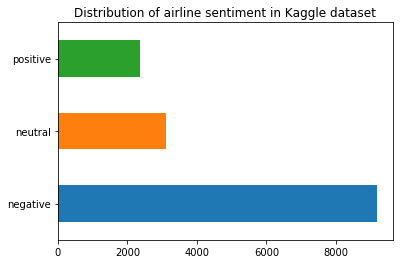

In [5]:
df['airline_sentiment'].value_counts().plot(kind='barh', 
                                            title='Distribution of airline sentiment in Kaggle dataset');
# Note: Dataset is biased toward negative tweets

## Preprocessing

In [6]:
class PreProcessor:
    '''
    Easily performs all the standard preprocessing steps
    like removing stopwords, stemming, etc.
    Only input that you need to provide is the dataframe
    '''
    def __init__(self, df, column_name):
        self.data = df
        self.conversations = list(self.data[column_name])
        self.stopwords = set(stopwords.words('english'))
        self.stemmer = SnowballStemmer("english")
        self.preprocessed = []
        
    def tokenize(self, sentence):
        '''
        Splits up words and makes a list of all words in the tweet
        '''
        tokenized_sentence = word_tokenize(sentence)
        return tokenized_sentence
            
    def remove_stopwords(self, sentence):
        '''Removes stopwords like 'a', 'the', 'and', etc.'''
        filtered_sentence = []
        for w in sentence:
            if w not in self.stopwords and len(w) > 1 and w[:2] != '//' and w != 'https': 
                filtered_sentence.append(w)
        return filtered_sentence
    
    def stem(self, sentence):
        '''
        Stems certain words to their root form.
        For example, words like 'computer', 'computation'
        all get trunacated to 'comput'
        '''
        return [self.stemmer.stem(word) for word in sentence]
    
    def join_to_string(self, sentence):
        '''
        Joins the tokenized words to one string.
        '''
        return ' '.join(sentence)
    
    def full_preprocess(self, n_rows=None):
        '''
        Preprocess a selected number of rows and
        connects them back to strings
        '''
        # If nothing is given do it for the whole dataset
        if n_rows == None:
            n_rows = len(self.data)
            
        # Perform preprocessing
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            joined = self.join_to_string(stemmed)
            self.preprocessed.append(joined)
        return self.get_data()
            
    def list_preprocess(self, n_rows=None):
        '''
        Preprocess everything but keep the
        tokenized version (list of words)
        '''
        # If nothing is given do it for the whole dataset
        if n_rows == None:
            n_rows = len(self.data)
            
        # Perform preprocessing
        for i in range(n_rows):
            tweet = self.conversations[i]
            tokenized = self.tokenize(tweet)
            cleaned = self.remove_stopwords(tokenized)
            stemmed = self.stem(cleaned)
            self.preprocessed.append(stemmed)
        return self.get_data()
    
    def get_data(self):
        '''
        Get the result of the preprocessing
        '''
        return self.preprocessed

In [7]:
# Preprocess text and put it in a new column
preprocessor = PreProcessor(df, 'text')
df['cleaned_text'] = preprocessor.full_preprocess()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Data transformation (to matrix)

In [8]:
# Shuffling so we can get random tweets for the test set
df = shuffle(df, random_state=seed)
# Keep 1000 samples of the data as test set
test_set = df[:1000]

In [9]:
# Get training and validation data
X_train, X_val, y_train, y_val = train_test_split(df['cleaned_text'][1000:], 
                                                  df['airline_sentiment'][1000:], 
                                                  test_size=0.2, 
                                                  random_state=seed)

# Get sentiment categories for test set
y_test = test_set['airline_sentiment']


In [10]:
# Create matrix based on word frequency in tweets
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(test_set['cleaned_text'])

print(f'Training size: {X_train.shape[0]} tweets\n\
Validation size: {X_val.shape[0]} tweets\n\
Test size: {X_test.shape[0]} tweets\n\
Amount of words (columns): {X_train.shape[1]} words')

Training size: 10912 tweets
Validation size: 2728 tweets
Test size: 1000 tweets
Amount of words (columns): 9672 words


## ML Models

### Multinomial Naive Bayes

In [11]:
# Multinomial Naive Bayes
multi_nb = MultinomialNB()
multi_nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [12]:
# Check results
train_pred = multi_nb.predict(X_train)
val_pred = multi_nb.predict(X_val)
print(f'Accuracy on training set (MultinomialNB): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (MultinomialNB): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

Accuracy on training set (MultinomialNB): 72.6998%
Accuracy on validation set (MultinomialNB): 69.1349%


### Sklearn's Gradient Boosting Machine (GBM)

In [13]:
gbm = GradientBoostingClassifier(n_estimators=200, 
                                 max_depth=6, 
                                 random_state=seed)
gbm.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              n_iter_no_change=None, presort='auto', random_state=1234,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [14]:
# Check results
train_pred = gbm.predict(X_train)
val_pred = gbm.predict(X_val)
print(f'Accuracy on training set (GBM): {round(accuracy_score(y_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (GBM): {round(accuracy_score(y_val,val_pred)*100, 4)}%')

Accuracy on training set (GBM): 87.5367%
Accuracy on validation set (GBM): 76.4663%


### XGBoost (GBM)

In [15]:
# Hyperparameters that you can tweak
# There are a lot more tweakable hyperparameters that you can find at 
# https://xgboost.readthedocs.io/en/latest/parameter.html
xgb_params = {'objective' : 'multi:softmax',
              'eval_metric' : 'mlogloss',
              'eta' : 0.1,
              'max_depth' : 6,
              'num_class' : 3,
              'lambda' : 0.8,
              'estimators' : 200,
              'seed' : seed
              
}

# Transform categories into numbers
# negative = 0, neutral = 1 and positive = 2
target_train = y_train.astype('category').cat.codes
target_val = y_val.astype('category').cat.codes

# Transform data into a matrix so that we can use XGBoost
d_train = xgb.DMatrix(X_train, label = target_train)
d_val = xgb.DMatrix(X_val, label = target_val)

# Fit XGBoost
watchlist = [(d_train, 'train'), (d_val, 'validation')]
bst = xgb.train(xgb_params, 
                d_train, 
                400,  
                watchlist,
                early_stopping_rounds = 50, 
                verbose_eval = 0)

In [16]:
# Check results for XGBoost
train_pred = bst.predict(d_train)
val_pred = bst.predict(d_val)
print(f'Accuracy on training set (XGBoost): {round(accuracy_score(target_train, train_pred)*100, 4)}%')
print(f'Accuracy on validation set (XGBoost): {round(accuracy_score(target_val, val_pred)*100, 4)}%')

Accuracy on training set (XGBoost): 89.5803%
Accuracy on validation set (XGBoost): 77.3827%


## Simple neural network / Multi-layered Perceptron (MLP)

In [17]:
# Generator so we can easily put small pieces of the data
# at once to the neural network
def batch_generator(X, y, batch_size, shuffle):
    number_of_batches = X.shape[0]/batch_size
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0

In [18]:
# Onehot encoding of target variable
# Negative = [1,0,0], Neutral = [0,1,0], Positive = [0,0,1]
# This makes it easy for the neural network to train

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_train = y_train.reshape(len(y_train), 1)
onehot_encoded_train = onehot_encoder.fit_transform(integer_encoded_train)

integer_encoded_val = y_val.reshape(len(y_val), 1)
onehot_encoded_val = onehot_encoder.fit_transform(integer_encoded_val)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


In [19]:
%%time
# For checking how long the training takes

# Neural network architecture
initializer = keras.initializers.he_normal(seed=seed)
activation = keras.activations.elu
optimizer = keras.optimizers.Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=4)

model = Sequential()
model.add(Dense(20, activation=activation, kernel_initializer=initializer, input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax', kernel_initializer=initializer))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Hyperparameters
epochs = 50
batch_size = 32

hist = model.fit_generator(generator=batch_generator(X_train, onehot_encoded_train, batch_size=batch_size, shuffle=True),
                           epochs=epochs, validation_data=(X_val, onehot_encoded_val),
                           steps_per_epoch=X_train.shape[0]/batch_size, callbacks=[es])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
341/341 [==============================] - 2s 5ms/step - loss: 0.5784 - acc: 0.6980 - val_loss: 0.5196 - val_acc: 0.8068
Epoch 2/50
341/341 [==============================] - 1s 4ms/step - loss: 0.5006 - acc: 0.7785 - val_loss: 0.4724 - val_acc: 0.7826
Epoch 3/50
341/341 [==============================] - 1s 4ms/step - loss: 0.4636 - acc: 0.7897 - val_loss: 0.4431 - val_acc: 0.7996
Epoch 4/50
341/341 [==============================] - 1s 4ms/step - loss: 0.4306 - acc: 0.8090 - val_loss: 0.4174 - val_acc: 0.8113
Epoch 5/50
341/341 [==============================] - 1s 4ms/step - loss: 0.4003 - acc: 0.8229 - val_loss: 0.3962 - val_acc: 0.8239
Epoch 6/50
341/341 [==============================] - 1s 4ms/step - loss: 0.3748 - acc: 0.8346 - val_loss

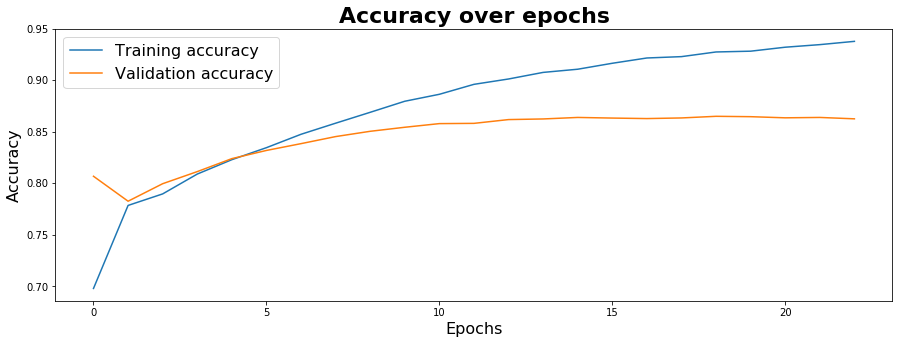

In [20]:
# Visualize Accuracy
acc = hist.history['acc']
val_acc = hist.history['val_acc']

# Get the amount of epochs for visualization
stopped_epoch = es.stopped_epoch
n_epochs = range(stopped_epoch+1)

plt.figure(figsize=(15,5))
plt.plot(n_epochs, acc)
plt.plot(n_epochs, val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

In [21]:
# Check results of neural network
train_pred = [np.argmax(pred) for pred in model.predict(X_train)]
val_pred = [np.argmax(pred) for pred in model.predict(X_val)]
print(f'Accuracy on training set (Small NN): {round(accuracy_score(target_train, train_pred)*100, 4)}%')
print(f'Accuracy on test set (Small NN): {round(accuracy_score(target_val, val_pred)*100, 4)}%')

Accuracy on training set (Small NN): 91.8897%
Accuracy on test set (Small NN): 78.7757%


### VADER (Pre-trained)

In [22]:
# This does not work well at the moment.
# Maybe we can change this so that it works better?

# Get predictions from Vader
sid = SentimentIntensityAnalyzer()
val_preds = []
for sentence in df['cleaned_text']:
    ss = sid.polarity_scores(sentence)
    val_preds.append(np.argmax([ss['neg'],ss['neu'],ss['pos']]))

# Get target values from dataset
target = df['airline_sentiment'].astype('category').cat.codes

print(f'Accuracy on dataset (VADER pre-trained): {round(accuracy_score(target, val_preds)*100, 4)}%')


Accuracy on dataset (VADER pre-trained): 25.2117%


Notes: VADER gives a lot of weight to neutrality. Does not seem very well suited for airline tweets.

## Rule based models

### Always predict negative

In [23]:
# Predict negative for the whole dataset
negative_pred_train = ['negative' for _ in range(len(y_train))]
negative_pred_val = ['negative' for _ in range(len(y_val))]

print(f'Accuracy on training set (Always predict negative): {round(accuracy_score(y_train, negative_pred_train)*100, 4)}%')
print(f'Accuracy on test set (Always predict negative): {round(accuracy_score(y_val, negative_pred_val)*100, 4)}%')

Accuracy on training set (Always predict negative): 62.445%
Accuracy on test set (Always predict negative): 63.5264%


### General rules based on word usage, length etc.

In [24]:
# A model which predicts based on rules
# For example 'fuck' in tweet would be 'negative'
# tweet_length < 2 would be 'neutral', etc.

## Model comparison with test set

After tweaking the models for a high validation accuracy here we can see how the models actually perform on new data.

In [25]:
# Multinomial Naive Bayes
multinb_test_pred = multi_nb.predict(X_test)

# Gradient Boosting Classifier
gbm_test_pred = gbm.predict(X_test)

# XGBoost
# Transform test data for XGBoost
target_test = y_test.astype('category').cat.codes
d_test = xgb.DMatrix(X_test, label = target_test)
xgboost_test_pred = bst.predict(d_test)

# Neural Network predictions
nn_test_pred = [np.argmax(pred) for pred in model.predict(X_test)]

# Get accuracies
print(f'Accuracy for Multinomial Naive Bayes: {round(accuracy_score(y_test, multinb_test_pred)*100, 4)}%')
print(f'Accuracy for Gradient Boosting Classifier: {round(accuracy_score(y_test, gbm_test_pred)*100, 4)}%')
print(f'Accuracy for XGBoost: {round(accuracy_score(target_test, xgboost_test_pred)*100, 4)}%')
print(f'Accuracy for Neural Network: {round(accuracy_score(target_test, nn_test_pred)*100, 4)}%')

Accuracy for Multinomial Naive Bayes: 67.8%
Accuracy for Gradient Boosting Classifier: 77.9%
Accuracy for XGBoost: 78.2%
Accuracy for Neural Network: 79.7%


## Save models

In [26]:
# Save XGBoost model
pickle.dump(bst, open('xgboost_1.dat', 'wb'))

# Save Neural Network model
model.save('nn_sentiment_model.h5')

## Make predictions

In [49]:
conn = sqlite3.connect('full_conversation_database.db')
df = pd.read_sql('SELECT id_str, text, lang from tweets', conn)

# Take only English tweets for our model
df = df[df['lang'] == 'en']

In [50]:
# Select British airways outgoing
#df['British_incoming'] = ['@British_Airways' in tweet for tweet in df['text']]
#df = df[df['British_incoming'] == True]

# Select KLM incoming
#df['KLM_incoming'] = ['@KLM' in tweet for tweet in df['text']]
#df = df[df['KLM_incoming'] == True]

In [51]:
# Preprocessing
sample = len(df)
preprocessor = PreProcessor(df, column_name='text')
preprocessor.full_preprocess(sample)
data = preprocessor.get_data()

# Transform data on the vectorizer used in the previous preprocessing
vectorized_data = vectorizer.transform(data)
print(f'Prediction data size: {vectorized_data.shape[0]} tweets\n\
Amount of words (columns): {vectorized_data.shape[1]} words')

Prediction data size: 149992 tweets
Amount of words (columns): 9672 words


In [52]:
# XGBoost
d_test = xgb.DMatrix(vectorized_data)
df_pred = pd.DataFrame({'tweet_id' : df['id_str'][:sample],
                        'tweet' : df['text'][:sample], 
                        'xgboost_pred' : bst.predict(d_test)})
# Convert to integers
df_pred['xgboost_pred'] = df_pred['xgboost_pred'].astype(int);

In [53]:
# Get predictions from neural network
df_pred['nn_pred'] = [np.argmax(model.predict(data)) for data in vectorized_data]

In [65]:
# Check if two models are in agreement
df_pred['pred_agreement'] = (df_pred['xgboost_pred'] == df_pred['nn_pred'])
print(f"The models agree with each other {round(df_pred['pred_agreement'].value_counts()[1]/len(df)*100, 4)}% of the time.")

The models agree with each other 68.1176% of the time.


In [57]:
# Save to csv
df_pred.to_csv('sentiments.csv', index=False)

In [35]:
# Final test
df_test = pd.read_csv('english_tweets_and_sentiments.csv'); df_test.head(2)

,tweet,tweet_id,xgboost_pred,nn_pred,pred_agreement
0,@johnnymowlem @VirginAtlantic @IMSA @BAR1Motor...,780682646854787072,0,1,False
1,Flew into Gatwick last night. 5 hour drive nor...,780682655104991232,0,0,True
